# Reading Source Images

In [1]:
import pathlib
import cv2
import matplotlib.pyplot as plt 

In [2]:
source_dir = './/data1/source'

path = pathlib.Path(source_dir)
path

WindowsPath('data1/source')

In [3]:
source_path = list(path.glob('*.*'))
print('Image Lenght : =========>: ' , len(source_path))
source_path 

Image Lenght : =========>:  2


[WindowsPath('data1/source/Aortic.jpg'),
 WindowsPath('data1/source/hoffa2.jpg')]

(200, 251, 3)


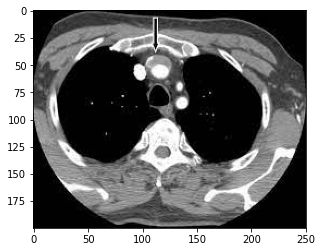

In [4]:
img = cv2.imread(str(source_path[0]))
print(img.shape)
plt.imshow(img)

In [5]:
hr_path = './/data/hr_image'
lr_path = './/lr_image'
hr_data = pathlib.Path(hr_path)
lr_data = path = pathlib.Path(lr_path)

# hr_data.glob('.')
hr_data

WindowsPath('data/hr_image')

In [6]:
str(source_path[0])

'data1\\source\\Aortic.jpg'

In [10]:
import numpy as np
# cv2.imwrite(str(source_path[0]))

In [11]:
# converting window path to image array
import numpy as np 
image_array = []
for win_path in source_path: 
    img = cv2.imread(str(win_path))
    image_array.append(img)
    
np_images = np.array(image_array, dtype=object)    

for img  in np_images:
    mr_image = cv2.resize(img, (128, 128))
    lr_image = cv2.resize(img, (32, 32))

    st = cv2.imwrite(mr_image, hr_path )
    print(st)
    
    

# print([im.shape for im in np_images])

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'imwrite'
> Overload resolution failed:
>  - Can't convert object to 'str' for 'filename'
>  - Can't convert object to 'str' for 'filename'


In [12]:
# converting to smaller dimenstions
np_images[0].shape

(200, 251, 3)

In [13]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import pathlib

In [19]:
train_dir = "data1" 
for img in os.listdir( train_dir + "/source"):
    img_array = cv2.imread(train_dir + "/source/" + img)
   
    img_array = cv2.resize(img_array, (128,128))
    print(img_array.shape)
    lr_img_array = cv2.resize(img_array,(32,32))
    cv2.imwrite(train_dir+ "/hr_images/" + img, img_array)
    cv2.imwrite(train_dir+ "/lr_images/"+ img, lr_img_array)
    

(128, 128, 3)
(128, 128, 3)


In [23]:
hr_images = list(pathlib.Path('.//data1/hr_images').glob("*.*"))
lr_images = list(pathlib.Path('.//data1/lr_images').glob("*.*"))

In [24]:
hr_images

[WindowsPath('data1/hr_images/Aortic.jpg'),
 WindowsPath('data1/hr_images/hoffa2.jpg')]

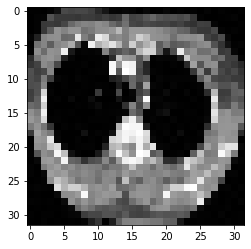

In [25]:
img = cv2.imread(str(lr_images[0]))
plt.imshow(img)

In [12]:
# ================================================================

In [26]:
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from keras.models import Sequential
from keras import layers, Model
from sklearn.model_selection import train_test_split

import numpy as np
from keras import Model
from keras.layers import Conv2D, PReLU,BatchNormalization, Flatten
from keras.layers import UpSampling2D, LeakyReLU, Dense, Input, add
from tqdm import tqdm

In [27]:
# Define blocks to build the generator
def res_block(ip):
    
    res_model = Conv2D(64, (3,3), padding = "same")(ip)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    res_model = PReLU(shared_axes = [1,2])(res_model)
    
    res_model = Conv2D(64, (3,3), padding = "same")(res_model)
    res_model = BatchNormalization(momentum = 0.5)(res_model)
    
    return add([ip,res_model])

In [28]:
def upscale_block(ip):
    
    up_model = Conv2D(256, (3,3), padding="same")(ip)
    up_model = UpSampling2D( size = 2 )(up_model)
    up_model = PReLU(shared_axes=[1,2])(up_model)
    
    return up_model

In [29]:
#Generator model
def create_gen(gen_ip, num_res_block):
    layers = Conv2D(64, (9,9), padding="same")(gen_ip)
    layers = PReLU(shared_axes=[1,2])(layers)

    temp = layers

    for i in range(num_res_block):
        layers = res_block(layers)

    layers = Conv2D(64, (3,3), padding="same")(layers)
    layers = BatchNormalization(momentum=0.5)(layers)
    layers = add([layers,temp])

    layers = upscale_block(layers)
    layers = upscale_block(layers)

    op = Conv2D(3, (9,9), padding="same")(layers)

    return Model(inputs=gen_ip, outputs=op)

In [30]:
#Descriminator block that will be used to construct the discriminator
def discriminator_block(ip, filters, strides=1, bn=True):
    
    disc_model = Conv2D(filters, (3,3), strides = strides, padding="same")(ip)
    
    if bn:
        disc_model = BatchNormalization( momentum=0.8 )(disc_model)
    
    disc_model = LeakyReLU( alpha=0.2 )(disc_model)
    
    return disc_model

In [31]:
#Descriminartor, as described in the original paper
def create_disc(disc_ip):

    df = 64
    
    d1 = discriminator_block(disc_ip, df, bn=False)
    d2 = discriminator_block(d1, df, strides=2)
    d3 = discriminator_block(d2, df*2)
    d4 = discriminator_block(d3, df*2, strides=2)
    d5 = discriminator_block(d4, df*4)
    d6 = discriminator_block(d5, df*4, strides=2)
    d7 = discriminator_block(d6, df*8)
    d8 = discriminator_block(d7, df*8, strides=2)
    
    d8_5 = Flatten()(d8)
    d9 = Dense(df*16)(d8_5)
    d10 = LeakyReLU(alpha=0.2)(d9)
    validity = Dense(1, activation='sigmoid')(d10)

    return Model(disc_ip, validity)

In [32]:
from tensorflow.keras.applications.vgg19 import VGG19

In [33]:
def build_vgg(hr_shape):
    
    vgg = VGG19(weights="imagenet",include_top=False, input_shape=hr_shape)
    
    return Model(inputs=vgg.inputs, outputs=vgg.layers[10].output)



In [34]:
#Combined model
def create_comb(gen_model, disc_model, vgg, lr_ip, hr_ip):
    gen_img = gen_model(lr_ip)
    
    gen_features = vgg(gen_img)
    
    disc_model.trainable = False
    validity = disc_model(gen_img)
    
    return Model(inputs=[lr_ip, hr_ip], outputs=[validity, gen_features])

In [35]:
n=2
lr_list = os.listdir("data1/lr_images")[:n]

lr_images = []
for img in lr_list:
    img_lr = cv2.imread("data1/lr_images/" + img)
    img_lr = cv2.cvtColor(img_lr, cv2.COLOR_BGR2RGB)
    lr_images.append(img_lr)   


hr_list = os.listdir("data1/hr_images")[:n]
   
hr_images = []
for img in hr_list:
    img_hr = cv2.imread("data1/hr_images/" + img)
    img_hr = cv2.cvtColor(img_hr, cv2.COLOR_BGR2RGB)
    hr_images.append(img_hr)   

lr_images = np.array(lr_images)
hr_images = np.array(hr_images)



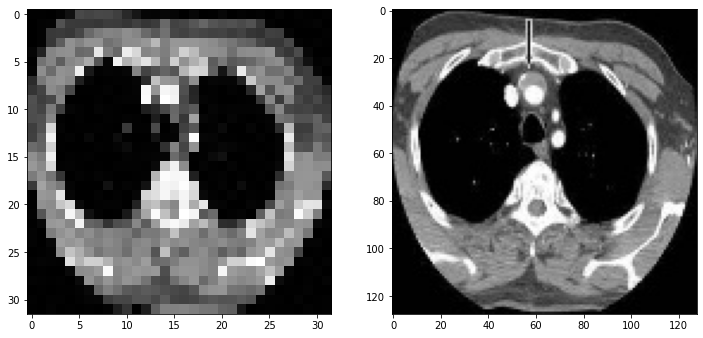

In [36]:
#Sanity check, view few mages
import random
import numpy as np
image_number = random.randint(0, len(lr_images)-1)
plt.figure(figsize=(12, 6))
plt.subplot(121)
plt.imshow(np.reshape(lr_images[image_number], (32, 32, 3)))
plt.subplot(122)
plt.imshow(np.reshape(hr_images[image_number], (128, 128, 3)))
plt.show()

In [39]:
#Scale values
lr_images = lr_images / 255.
hr_images = hr_images / 255.

#Split to train and test
lr_train, lr_test, hr_train, hr_test = train_test_split(lr_images, hr_images, 
                                                      test_size=0.33, random_state=42)

In [43]:
hr_shape = (hr_images.shape[1], hr_images.shape[2], hr_images.shape[3])
lr_shape = (lr_images.shape[1], lr_images.shape[2], lr_images.shape[3])

lr_ip = Input(shape=lr_shape)
hr_ip = Input(shape=hr_shape)

generator = create_gen(lr_ip, num_res_block = 16)
generator.summary()


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 conv2d (Conv2D)                (None, 32, 32, 64)   15616       ['input_1[0][0]']                
                                                                                                  
 p_re_lu (PReLU)                (None, 32, 32, 64)   64          ['conv2d[0][0]']                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 32, 32, 64)   36928       ['p_re_lu[0][0]']                
                                                                                              

In [44]:
discriminator = create_disc(hr_ip)
discriminator.compile(loss="binary_crossentropy", optimizer="adam", metrics=['accuracy'])
discriminator.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 conv2d_37 (Conv2D)          (None, 128, 128, 64)      1792      
                                                                 
 leaky_re_lu (LeakyReLU)     (None, 128, 128, 64)      0         
                                                                 
 conv2d_38 (Conv2D)          (None, 64, 64, 64)        36928     
                                                                 
 batch_normalization_33 (Bat  (None, 64, 64, 64)       256       
 chNormalization)                                                
                                                                 
 leaky_re_lu_1 (LeakyReLU)   (None, 64, 64, 64)        0         
                                                           

In [45]:

vgg = build_vgg((128,128,3))
print(vgg.summary())
vgg.trainable = False

gan_model = create_comb(generator, discriminator, vgg, lr_ip, hr_ip)

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_3 (InputLayer)        [(None, 128, 128, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 128, 128, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 128, 128, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 64, 64, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 64, 64, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 64, 64, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 32, 32, 128)       0   

In [46]:
#Content: feature map obtained by the j-th convolution (after activation) 
#before the i-th maxpooling layer within the VGG19 network.
# MSE between the feature representations of a reconstructed image
# and the reference image. 
gan_model.compile(loss=["binary_crossentropy", "mse"], loss_weights=[1e-3, 1], optimizer="adam")
gan_model.summary()

Model: "model_3"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 32, 32, 3)]  0           []                               
                                                                                                  
 model (Functional)             (None, 128, 128, 3)  2044291     ['input_1[0][0]']                
                                                                                                  
 input_2 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 model_1 (Functional)           (None, 1)            38249281    ['model[0][0]']            

In [47]:
#Create a list of images for LR and HR in batches from which a batch of images
#would be fetched during training. 
batch_size = 1  
train_lr_batches = []
train_hr_batches = []
for it in range(int(hr_train.shape[0] / batch_size)):
    start_idx = it * batch_size
    end_idx = start_idx + batch_size
    train_hr_batches.append(hr_train[start_idx:end_idx])
    train_lr_batches.append(lr_train[start_idx:end_idx])

In [48]:
epochs = 200
#Enumerate training over epochs
for e in range(epochs):
    
    fake_label = np.zeros((batch_size, 1)) # Assign a label of 0 to all fake (generated images)
    real_label = np.ones((batch_size,1)) # Assign a label of 1 to all real images.
    
    #Create empty lists to populate gen and disc losses. 
    g_losses = []
    d_losses = []
    
    #Enumerate training over batches. 
    for b in tqdm(range(len(train_hr_batches))):
        lr_imgs = train_lr_batches[b] #Fetch a batch of LR images for training
        hr_imgs = train_hr_batches[b] #Fetch a batch of HR images for training
        
        fake_imgs = generator.predict_on_batch(lr_imgs) #Fake images
        
        #First, train the discriminator on fake and real HR images. 
        discriminator.trainable = True
        d_loss_gen = discriminator.train_on_batch(fake_imgs, fake_label)
        d_loss_real = discriminator.train_on_batch(hr_imgs, real_label)
        
        #Now, train the generator by fixing discriminator as non-trainable
        discriminator.trainable = False
        
        #Average the discriminator loss, just for reporting purposes. 
        d_loss = 0.5 * np.add(d_loss_gen, d_loss_real) 
        
        #Extract VGG features, to be used towards calculating loss
        image_features = vgg.predict(hr_imgs)
     
        #Train the generator via GAN. 
        #Remember that we have 2 losses, adversarial loss and content (VGG) loss
        g_loss, _, _ = gan_model.train_on_batch([lr_imgs, hr_imgs], [real_label, image_features])
        
        #Save losses to a list so we can average and report. 
        d_losses.append(d_loss)
        g_losses.append(g_loss)
        
    #Convert the list of losses to an array to make it easy to average    
    g_losses = np.array(g_losses)
    d_losses = np.array(d_losses)
    
    #Calculate the average losses for generator and discriminator
    g_loss = np.sum(g_losses, axis=0) / len(g_losses)
    d_loss = np.sum(d_losses, axis=0) / len(d_losses)
    
    #Report the progress during training. 
    print("epoch:", e+1 ,"g_loss:", g_loss, "d_loss:", d_loss)

    if (e+1) % 10 == 0: #Change the frequency for model saving, if needed
        #Save the generator after every n epochs (Usually 10 epochs)
        generator.save("gen_e_"+ str(e+1) +".h5")

  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 482ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:17<00:00, 17.27s/it]


epoch: 1 g_loss: 480.6726379394531 d_loss: [0.21891392 1.        ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 128ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.30s/it]


epoch: 2 g_loss: 1720.0723876953125 d_loss: [84.35329247  0.        ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.94s/it]


epoch: 3 g_loss: 365.20849609375 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.10s/it]


epoch: 4 g_loss: 158.36241149902344 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.75s/it]


epoch: 5 g_loss: 88.02091217041016 d_loss: [95.21191822  0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.14s/it]


epoch: 6 g_loss: 47.075260162353516 d_loss: [91.74701691  0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 104ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.11s/it]


epoch: 7 g_loss: 28.24139404296875 d_loss: [9.03890133 0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 120ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.27s/it]


epoch: 8 g_loss: 20.400785446166992 d_loss: [1.05097552e-16 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.86s/it]


epoch: 9 g_loss: 11.561104774475098 d_loss: [1.60261587e-29 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 94ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.02s/it]

epoch: 10 g_loss: 3.650141716003418 d_loss: [10.34861565  0.5       ]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.69s/it]


epoch: 11 g_loss: 1.3251676559448242 d_loss: [2.71952335e-31 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.87s/it]


epoch: 12 g_loss: 2.0397958755493164 d_loss: [2.05250365e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.89s/it]


epoch: 13 g_loss: 3.085341215133667 d_loss: [4.62369713e-31 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.97s/it]


epoch: 14 g_loss: 5.877936363220215 d_loss: [2.6960125 0.5      ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.91s/it]


epoch: 15 g_loss: 4.174256324768066 d_loss: [1.02708959e-13 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.01s/it]


epoch: 16 g_loss: 5.678640365600586 d_loss: [0.00234857 1.        ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.02s/it]


epoch: 17 g_loss: 6.521088600158691 d_loss: [8.35827541 0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 109ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.08s/it]


epoch: 18 g_loss: 5.543475151062012 d_loss: [2.55108375e-06 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.07s/it]


epoch: 19 g_loss: 8.860345840454102 d_loss: [2.09837529e-12 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.13s/it]

epoch: 20 g_loss: 8.360492706298828 d_loss: [1.50811424e-16 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:03<00:00,  3.96s/it]


epoch: 21 g_loss: 6.165861129760742 d_loss: [1.43840828e-19 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.18s/it]


epoch: 22 g_loss: 2.4990878105163574 d_loss: [7.29722591e-22 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.17s/it]


epoch: 23 g_loss: 25.558088302612305 d_loss: [1.19384545e-23 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.18s/it]


epoch: 24 g_loss: 2.9667227268218994 d_loss: [4.67327363e-25 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it]


epoch: 25 g_loss: 14.009710311889648 d_loss: [3.44602485e-26 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.26s/it]


epoch: 26 g_loss: 14.632434844970703 d_loss: [4.20468448e-27 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.34s/it]


epoch: 27 g_loss: 10.064102172851562 d_loss: [7.75891837e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.32s/it]


epoch: 28 g_loss: 10.873953819274902 d_loss: [2.52667952e-21 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


epoch: 29 g_loss: 11.110128402709961 d_loss: [1.15646467e-14 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]

epoch: 30 g_loss: 0.15492463111877441 d_loss: [22.66007233  0.5       ]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 168ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


epoch: 31 g_loss: 9.556747436523438 d_loss: [4.58686734e-12 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


epoch: 32 g_loss: 0.4057764708995819 d_loss: [7.38559931e-04 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.38s/it]


epoch: 33 g_loss: 1.7022886276245117 d_loss: [3.69872546 0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


epoch: 34 g_loss: 1.8323616981506348 d_loss: [2.01949688e-16 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.40s/it]


epoch: 35 g_loss: 1.6086974143981934 d_loss: [3.19206902e-31 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.42s/it]


epoch: 36 g_loss: 1.4549875259399414 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 37 g_loss: 1.2062665224075317 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


epoch: 38 g_loss: 1.0590389966964722 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


epoch: 39 g_loss: 1.1161580085754395 d_loss: [6.6260482e-38 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]

epoch: 40 g_loss: 1.3183430433273315 d_loss: [2.93916291e-35 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.23s/it]


epoch: 41 g_loss: 1.5063356161117554 d_loss: [3.03496478e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


epoch: 42 g_loss: 1.6031827926635742 d_loss: [6.69517854e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


epoch: 43 g_loss: 1.5897324085235596 d_loss: [5.36609974e-31 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.46s/it]


epoch: 44 g_loss: 1.477265477180481 d_loss: [2.04770401e-30 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


epoch: 45 g_loss: 1.312197208404541 d_loss: [5.23590161e-30 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.43s/it]


epoch: 46 g_loss: 1.1349759101867676 d_loss: [1.07905236e-29 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.48s/it]


epoch: 47 g_loss: 1.0002714395523071 d_loss: [1.93186978e-29 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


epoch: 48 g_loss: 0.9314594268798828 d_loss: [3.17567582e-29 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


epoch: 49 g_loss: 0.9107966423034668 d_loss: [4.97219711e-29 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.54s/it]

epoch: 50 g_loss: 0.9023078083992004 d_loss: [7.70661469e-29 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.22s/it]


epoch: 51 g_loss: 0.8693839907646179 d_loss: [1.15012781e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


epoch: 52 g_loss: 0.8078973889350891 d_loss: [1.61333201e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 184ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.03s/it]


epoch: 53 g_loss: 0.7221457362174988 d_loss: [2.12836781e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.79s/it]


epoch: 54 g_loss: 0.6304177641868591 d_loss: [2.67055946e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 160ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]


epoch: 55 g_loss: 0.5561593174934387 d_loss: [3.22681931e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


epoch: 56 g_loss: 0.5082631707191467 d_loss: [3.78472847e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 181ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


epoch: 57 g_loss: 0.48718610405921936 d_loss: [4.29622441e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.14s/it]


epoch: 58 g_loss: 0.4767875373363495 d_loss: [4.75594003e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 59 g_loss: 0.464679479598999 d_loss: [5.2034313e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 203ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.94s/it]

epoch: 60 g_loss: 0.4468965530395508 d_loss: [5.5771243e-28 1.0000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.37s/it]


epoch: 61 g_loss: 0.42377424240112305 d_loss: [5.89792501e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.83s/it]


epoch: 62 g_loss: 0.396716445684433 d_loss: [6.18132608e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


epoch: 63 g_loss: 0.36834001541137695 d_loss: [6.40435984e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


epoch: 64 g_loss: 0.34222352504730225 d_loss: [6.62967246e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.78s/it]


epoch: 65 g_loss: 0.32143986225128174 d_loss: [6.77685251e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 66 g_loss: 0.30782321095466614 d_loss: [6.93753429e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


epoch: 67 g_loss: 0.2995436191558838 d_loss: [7.04369396e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


epoch: 68 g_loss: 0.29488247632980347 d_loss: [7.16070479e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 69 g_loss: 0.29096201062202454 d_loss: [7.25686888e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]

epoch: 70 g_loss: 0.2851716876029968 d_loss: [7.32472999e-28 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.29s/it]


epoch: 71 g_loss: 0.2769378423690796 d_loss: [7.36884245e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


epoch: 72 g_loss: 0.266838014125824 d_loss: [7.43236203e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


epoch: 73 g_loss: 0.2563897371292114 d_loss: [7.4557327e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.51s/it]


epoch: 74 g_loss: 0.2468685805797577 d_loss: [7.50132043e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 75 g_loss: 0.23906052112579346 d_loss: [7.5199721e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.82s/it]


epoch: 76 g_loss: 0.23205125331878662 d_loss: [7.54097148e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


epoch: 77 g_loss: 0.22373482584953308 d_loss: [7.55934677e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


epoch: 78 g_loss: 0.22482039034366608 d_loss: [7.57192984e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


epoch: 79 g_loss: 0.22089612483978271 d_loss: [7.58187293e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]

epoch: 80 g_loss: 0.2133309692144394 d_loss: [7.59466736e-28 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


epoch: 81 g_loss: 0.2108342945575714 d_loss: [7.60171049e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 125ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.52s/it]


epoch: 82 g_loss: 0.2050183117389679 d_loss: [7.60382757e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 83 g_loss: 0.19730828702449799 d_loss: [7.59770985e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.55s/it]


epoch: 84 g_loss: 0.1945638507604599 d_loss: [7.59347955e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


epoch: 85 g_loss: 0.1907259225845337 d_loss: [7.58765939e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 86 g_loss: 0.18479900062084198 d_loss: [7.59968104e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.91s/it]


epoch: 87 g_loss: 0.1823020577430725 d_loss: [7.61169259e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 88 g_loss: 0.17947480082511902 d_loss: [7.62267616e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 89 g_loss: 0.17524626851081848 d_loss: [7.62189135e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]

epoch: 90 g_loss: 0.1729080080986023 d_loss: [7.61619445e-28 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


epoch: 91 g_loss: 0.17005860805511475 d_loss: [7.6166013e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.53s/it]


epoch: 92 g_loss: 0.16540133953094482 d_loss: [7.61613619e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.60s/it]


epoch: 93 g_loss: 0.16183771193027496 d_loss: [7.6190713e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 94 g_loss: 0.15810935199260712 d_loss: [7.6187516e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 95 g_loss: 0.1534198820590973 d_loss: [7.62017583e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 151ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.87s/it]


epoch: 96 g_loss: 0.14948007464408875 d_loss: [7.61622334e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.43s/it]


epoch: 97 g_loss: 0.14533552527427673 d_loss: [7.61619445e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


epoch: 98 g_loss: 0.13957622647285461 d_loss: [7.61334792e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 99 g_loss: 0.13390898704528809 d_loss: [7.6123604e-28 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]

epoch: 100 g_loss: 0.12665775418281555 d_loss: [7.61151829e-28 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.36s/it]


epoch: 101 g_loss: 0.11727859079837799 d_loss: [7.61358e-28 1.00000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


epoch: 102 g_loss: 0.10759119689464569 d_loss: [8.22707782e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 103 g_loss: 0.09415779262781143 d_loss: [1.0223449e-19 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 104 g_loss: 0.06623320281505585 d_loss: [3.56665614e-10 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]


epoch: 105 g_loss: 0.22551625967025757 d_loss: [4.79856539 0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


epoch: 106 g_loss: 0.3371901512145996 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


epoch: 107 g_loss: 0.38504117727279663 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


epoch: 108 g_loss: 0.39360716938972473 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 109 g_loss: 0.37666448950767517 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]

epoch: 110 g_loss: 0.31789806485176086 d_loss: [0. 1.]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.44s/it]


epoch: 111 g_loss: 0.32400375604629517 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.80s/it]


epoch: 112 g_loss: 0.37506526708602905 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 178ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 113 g_loss: 0.2841859459877014 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 114 g_loss: 0.18251025676727295 d_loss: [3.20632391e-38 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 115 g_loss: 0.08507236838340759 d_loss: [2.42052943e-37 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 116 g_loss: 0.062231048941612244 d_loss: [1.34375339e-36 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.95s/it]


epoch: 117 g_loss: 0.05865338817238808 d_loss: [6.08412243e-36 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.89s/it]


epoch: 118 g_loss: 0.06366797536611557 d_loss: [2.2983496e-35 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.75s/it]


epoch: 119 g_loss: 0.07404815405607224 d_loss: [7.12482221e-35 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]

epoch: 120 g_loss: 0.08351881057024002 d_loss: [1.84505157e-34 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.47s/it]


epoch: 121 g_loss: 0.08825937658548355 d_loss: [4.09633103e-34 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 122 g_loss: 0.08518469333648682 d_loss: [7.96637848e-34 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


epoch: 123 g_loss: 0.0794772058725357 d_loss: [1.37745429e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 124 g_loss: 0.0727584958076477 d_loss: [2.16948797e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 125 g_loss: 0.06994613260030746 d_loss: [3.14389638e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 126 g_loss: 0.06847165524959564 d_loss: [4.28469124e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 127 g_loss: 0.067262664437294 d_loss: [5.50513722e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 128 g_loss: 0.06383305042982101 d_loss: [6.86150673e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 129 g_loss: 0.05720984935760498 d_loss: [8.07441339e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]

epoch: 130 g_loss: 0.05001203715801239 d_loss: [9.48607925e-33 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.45s/it]


epoch: 131 g_loss: 0.04296695068478584 d_loss: [1.09959878e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


epoch: 132 g_loss: 0.038032982498407364 d_loss: [1.22106996e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 133 g_loss: 0.03551892936229706 d_loss: [1.31708206e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


epoch: 134 g_loss: 0.03336159884929657 d_loss: [1.403814e-32 1.000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


epoch: 135 g_loss: 0.031450867652893066 d_loss: [1.48036072e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 136 g_loss: 0.02894224226474762 d_loss: [1.5425764e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.99s/it]


epoch: 137 g_loss: 0.025860590860247612 d_loss: [1.59467887e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


epoch: 138 g_loss: 0.023134544491767883 d_loss: [1.641588e-32 1.000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.06s/it]


epoch: 139 g_loss: 0.02129899151623249 d_loss: [1.6806197e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.11s/it]

epoch: 140 g_loss: 0.020120538771152496 d_loss: [1.71128453e-32 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


epoch: 141 g_loss: 0.019712455570697784 d_loss: [1.73513281e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 142 g_loss: 0.019462335854768753 d_loss: [1.75706004e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


epoch: 143 g_loss: 0.018740493804216385 d_loss: [1.77074618e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.64s/it]


epoch: 144 g_loss: 0.017597045749425888 d_loss: [1.78466153e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.04s/it]


epoch: 145 g_loss: 0.016333313658833504 d_loss: [1.79974327e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.15s/it]


epoch: 146 g_loss: 0.015173438936471939 d_loss: [1.81088593e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 192ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.09s/it]


epoch: 147 g_loss: 0.014309088699519634 d_loss: [1.81676722e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.08s/it]


epoch: 148 g_loss: 0.013846337795257568 d_loss: [1.82568775e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.12s/it]


epoch: 149 g_loss: 0.013510284945368767 d_loss: [1.82833614e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.49s/it]

epoch: 150 g_loss: 0.013098318129777908 d_loss: [1.82994099e-32 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.59s/it]


epoch: 151 g_loss: 0.012503175064921379 d_loss: [1.83309895e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 192ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.93s/it]


epoch: 152 g_loss: 0.011765774339437485 d_loss: [1.83637447e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 153 g_loss: 0.011014342308044434 d_loss: [1.83959973e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


epoch: 154 g_loss: 0.010395735502243042 d_loss: [1.84179056e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


epoch: 155 g_loss: 0.009990162216126919 d_loss: [1.84235274e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.76s/it]


epoch: 156 g_loss: 0.009779302403330803 d_loss: [1.84309785e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


epoch: 157 g_loss: 0.009620372205972672 d_loss: [1.8437025e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 158 g_loss: 0.009382899850606918 d_loss: [1.8444482e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


epoch: 159 g_loss: 0.009040061384439468 d_loss: [1.84567292e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.80s/it]

epoch: 160 g_loss: 0.008672370575368404 d_loss: [1.84705339e-32 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.50s/it]


epoch: 161 g_loss: 0.008383776992559433 d_loss: [1.84560254e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.70s/it]


epoch: 162 g_loss: 0.008216628804802895 d_loss: [1.85666356e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


epoch: 163 g_loss: 0.008134894073009491 d_loss: [7.71732341e-31 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.58s/it]


epoch: 164 g_loss: 0.008063077926635742 d_loss: [2.04674299e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 165 g_loss: 0.007940522395074368 d_loss: [1.07238321e-27 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 166 g_loss: 0.007760040462017059 d_loss: [1.41241289e-28 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 167 g_loss: 0.007561614736914635 d_loss: [1.06365521e-30 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.68s/it]


epoch: 168 g_loss: 0.007394787389785051 d_loss: [1.96650126e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:05<00:00,  5.01s/it]


epoch: 169 g_loss: 0.007281382568180561 d_loss: [1.84902593e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]

epoch: 170 g_loss: 0.007204064168035984 d_loss: [1.84901323e-32 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.57s/it]


epoch: 171 g_loss: 0.007124743424355984 d_loss: [1.84884396e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 172 g_loss: 0.007016053423285484 d_loss: [1.84885807e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.62s/it]


epoch: 173 g_loss: 0.006878155283629894 d_loss: [1.84925304e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 174 g_loss: 0.006734168156981468 d_loss: [1.84985974e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 175 g_loss: 0.006609377916902304 d_loss: [1.8502691e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.74s/it]


epoch: 176 g_loss: 0.006512423045933247 d_loss: [1.85042442e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 177 g_loss: 0.006432041991502047 d_loss: [1.8505092e-32 1.0000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.63s/it]


epoch: 178 g_loss: 0.006350228097289801 d_loss: [1.85021268e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.61s/it]


epoch: 179 g_loss: 0.006255351006984711 d_loss: [1.84998684e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]

epoch: 180 g_loss: 0.0061492230743169785 d_loss: [1.84993041e-32 1.00000000e+00]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 172ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.41s/it]


epoch: 181 g_loss: 0.006333902943879366 d_loss: [1.84997273e-32 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 182 g_loss: 3.184502124786377 d_loss: [52.2083931  0.5      ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 183 g_loss: 4.0078887939453125 d_loss: [10.77213669  0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 184 g_loss: 4.488773822784424 d_loss: [4.13754155e-26 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.94s/it]


epoch: 185 g_loss: 3.1424965858459473 d_loss: [6.65959059e-33 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 186 g_loss: 2.964728832244873 d_loss: [9.41803594e-34 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.77s/it]


epoch: 187 g_loss: 0.394122838973999 d_loss: [2.94282195e-19 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.69s/it]


epoch: 188 g_loss: 25.72369384765625 d_loss: [13.24411107  0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 189 g_loss: 24.987947463989258 d_loss: [97.93357849  0.5       ]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]

epoch: 190 g_loss: 74.72935485839844 d_loss: [0. 1.]



  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.54s/it]


epoch: 191 g_loss: 30.43960189819336 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.66s/it]


epoch: 192 g_loss: 11.112381935119629 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.64s/it]


epoch: 193 g_loss: 7.5663981437683105 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]


epoch: 194 g_loss: 5.32377290725708 d_loss: [0. 1.]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.67s/it]


epoch: 195 g_loss: 2.288437604904175 d_loss: [1.88632061e-35 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.72s/it]


epoch: 196 g_loss: 0.358529269695282 d_loss: [7.03820791e-30 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 187ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 197 g_loss: 2.0460593700408936 d_loss: [8.77935134e-25 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.65s/it]


epoch: 198 g_loss: 5.217474937438965 d_loss: [2.50331947e-20 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 141ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.71s/it]


epoch: 199 g_loss: 7.596037864685059 d_loss: [1.28946155e-16 1.00000000e+00]


  0%|                                                                                       | 0/1 [00:00<?, ?it/s]

1/1 [==============================] - 0s 156ms/step


100%|███████████████████████████████████████████████████████████████████████████████| 1/1 [00:04<00:00,  4.73s/it]

epoch: 200 g_loss: 1.9682483673095703 d_loss: [1.60588096e-13 1.00000000e+00]


In [1]:
###################################################################################
#Test - perform super resolution using saved generator model
from keras.models import load_model
from numpy.random import randint

generator = load_model('gen_e_10.h5', compile=False)


[X1, X2] = [lr_test, hr_test]
# select random example
ix = randint(0, len(X1), 1)
src_image, tar_image = X1[ix], X2[ix]

# generate image from source
gen_image = generator.predict(src_image)


# plot all three images

plt.figure(figsize=(16, 8))
plt.subplot(231)
plt.title('LR Image')
plt.imshow(src_image[0,:,:,:])
plt.subplot(232)
plt.title('Superresolution')
plt.imshow(gen_image[0,:,:,:])
plt.subplot(233)
plt.title('Orig. HR image')
plt.imshow(tar_image[0,:,:,:])

plt.show()


#         prediction section
################################################
# sreeni_lr = cv2.imread("data/sreeni_32.jpg")
# sreeni_hr = cv2.imread("data/sreeni_256.jpg")

# #Change images from BGR to RGB for plotting. 
# #Remember that we used cv2 to load images which loads as BGR.
# sreeni_lr = cv2.cvtColor(sreeni_lr, cv2.COLOR_BGR2RGB)
# sreeni_hr = cv2.cvtColor(sreeni_hr, cv2.COLOR_BGR2RGB)

# sreeni_lr = sreeni_lr / 255.
# sreeni_hr = sreeni_hr / 255.

# sreeni_lr = np.expand_dims(sreeni_lr, axis=0)
# sreeni_hr = np.expand_dims(sreeni_hr, axis=0)

# generated_sreeni_hr = generator.predict(sreeni_lr)

# # plot all three images
# plt.figure(figsize=(16, 8))
# plt.subplot(231)
# plt.title('LR Image')
# plt.imshow(sreeni_lr[0,:,:,:])
# plt.subplot(232)
# plt.title('Superresolution')
# plt.imshow(generated_sreeni_hr[0,:,:,:])
# plt.subplot(233)
# plt.title('Orig. HR image')
# plt.imshow(sreeni_hr[0,:,:,:])

# plt.show()

NameError: name 'lr_test' is not defined

In [52]:
import tensorflow as tf
import math
from skimage.metrics import structural_similarity as ssim

In [36]:
# defining the signal to noise ratio
def psnr(target, ref): 
    
    target_data = target.astype(float)
    ref_data = ref.astype(float)
    
    diff = ref_data - target_data
    diff = diff.flatten('C')
    
    rmse = math.sqrt(np.mean(diff ** 2.))
    
    return 20 * math.log10(255./rmse)

#  defining function for the mean squared error (MSE)
def mse(target, ref):
    
    err = np.sum((target.astype('float')) - ref.astype('float') ** 2)
    err /= float(target.shape[0] *target.shape[1])
    return err

# function to combined
def compare_image(target, ref):
    scores = []
    scores.append(psnr(target,ref))
    scores.append(mse(target, ref))
    scores.append(ssim(target, rel, multichannel=True))
    
    return scores

In [41]:
img = cv2.resize(gen_image[0,:,:,:], (128,128,3))
compare_image(gen_image[0,:,:,:],src_image[0,:,:,:])

error: OpenCV(4.5.5) :-1: error: (-5:Bad argument) in function 'resize'
> Overload resolution failed:
>  - Can't parse 'dsize'. Expected sequence length 2, got 3
>  - Can't parse 'dsize'. Expected sequence length 2, got 3


In [2]:
import matplotlib.pyplot as plt

In [8]:
image = ['Abdomen Image', 'Knee Image']
psnr = [27.108 , 36.357]
ssim = [25.502 , 35.309]
espcn = [25.080 , 35.131]


import numpy as np

xpos  = np.arange(len(image))
xpos

array([0, 1])

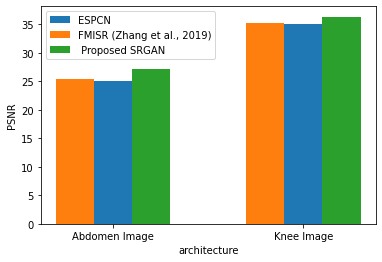

In [14]:
plt.xticks(xpos, image)
plt.bar(xpos, espcn, width=0.2, label='ESPCN')
plt.bar(xpos-0.2, ssim, width=0.2, label='FMISR (Zhang et al., 2019)')
plt.bar(xpos+0.2, psnr, width=0.2, label=' Proposed SRGAN')
plt.ylabel('PSNR')
plt.xlabel('architecture')
plt.legend()